## Импорты

In [78]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import torch.optim as optim
import numpy as np
from torchsummary import summary
import shutil
import random
from collections import defaultdict
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader, WeightedRandomSampler
import torch
from torchvision import models
from torchview import draw_graph

## Проверяем, что все загрузилось, смотрим сколько классов, сколько примеров в данных и смотрим на примеры данных из классов

Найдено классов: 10
Классы: ['PermanentCrop', 'Highway', 'Pasture', 'AnnualCrop', 'SeaLake', 'Forest', 'Industrial', 'Residential', 'River', 'HerbaceousVegetation']

 Распределение по классам:
  PermanentCrop: 2500 изображений
  Highway: 2500 изображений
  Pasture: 2000 изображений
  AnnualCrop: 3000 изображений
  SeaLake: 3000 изображений
  Forest: 3000 изображений
  Industrial: 2500 изображений
  Residential: 3000 изображений
  River: 2500 изображений
  HerbaceousVegetation: 2220 изображений


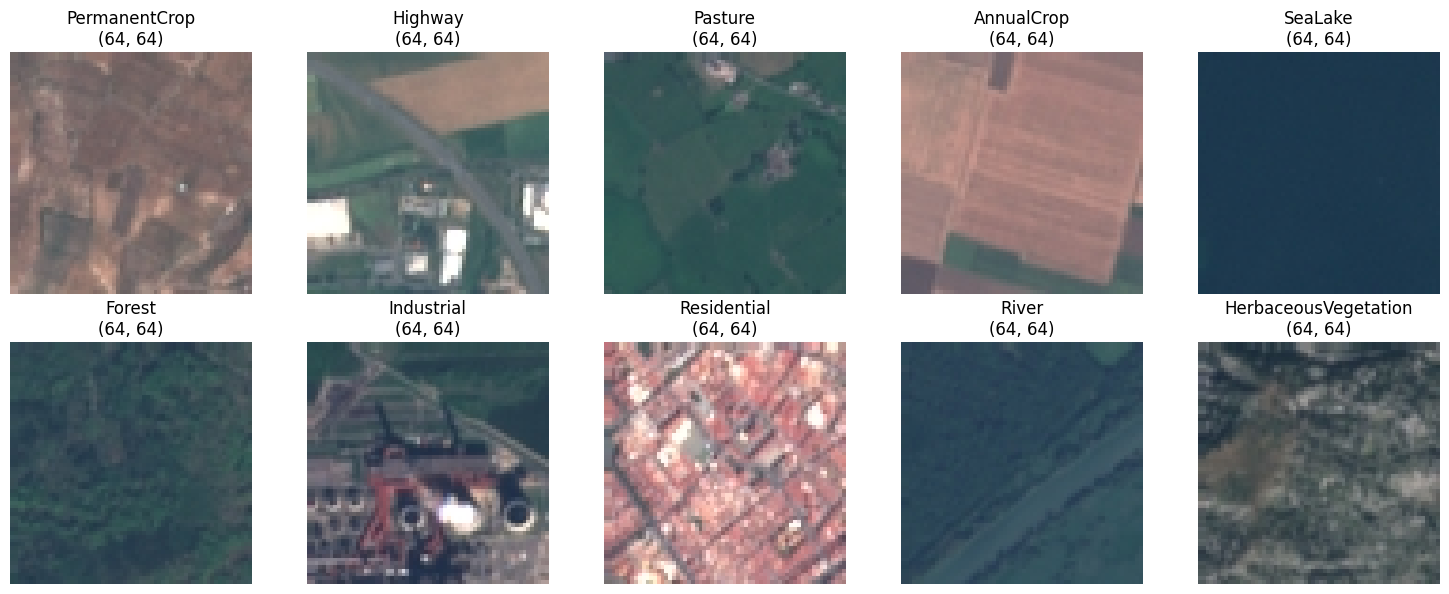

In [79]:
dataset_path = "EuroSAT_RGB/"

classes = os.listdir(dataset_path)
print(f"Найдено классов: {len(classes)}")
print(f"Классы: {classes}")


class_counts = {}
image_paths = {}

for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        class_counts[class_name] = len(images)
        if images:
            image_paths[class_name] = os.path.join(class_path, images[0])

print("\n Распределение по классам:")
for class_name, count in class_counts.items():
    print(f"  {class_name}: {count} изображений")

# Покажем по одному изображению из каждого класса
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for idx, (class_name, image_path) in enumerate(image_paths.items()):
    if idx < 10:  # У нас 10 классов
        img = Image.open(image_path)
        axes[idx].imshow(img)
        axes[idx].set_title(f"{class_name}\n{img.size}")
        axes[idx].axis('off')

plt.tight_layout()
plt.show()

## Впринципе довольно много данных, более менее сбалансированные

# Делим данные на train, test и val

In [80]:
splits_path = "Splits_EuroSAT_RGB"

def create_splits_with_original_train(dataset_path=dataset_path, output_path=splits_path,
                                     val_ratio=0.15, test_ratio=0.15, random_seed=42):
    """
    Для train берем все доступные данные (с аугментацией),
    для val/test - сбалансированные подмножества
    """
    
    random.seed(random_seed)
    np.random.seed(random_seed)
    
    # Создаем структуру папок
    splits = ['train', 'val', 'test']
    for split in splits:
        split_path = os.path.join(output_path, split)
        os.makedirs(split_path, exist_ok=True)
    
    classes = [c for c in os.listdir(dataset_path) 
               if os.path.isdir(os.path.join(dataset_path, c))]
    
    print(" Статистика по классам:")
    class_images = defaultdict(list)
    
    for class_name in classes:
        class_path = os.path.join(dataset_path, class_name)
        images = [img for img in os.listdir(class_path) 
                 if img.lower().endswith(('.jpg', '.png', '.jpeg'))]
        class_images[class_name] = images
        print(f"  {class_name}: {len(images)} изображений")
    
    # Для val/test берем сбалансированно, для train - все остальное
    min_images_per_class = min(len(images) for images in class_images.values())
    val_count_per_class = int(min_images_per_class * val_ratio)
    test_count_per_class = int(min_images_per_class * test_ratio)
    
    print(f"\n Балансировка для val/test:")
    print(f"  Val: {val_count_per_class} на класс")
    print(f"  Test: {test_count_per_class} на класс")
    print(f"  Train: все оставшиеся изображения")
    
    total_copied = 0
    
    for class_name in classes:
        print(f"\n Обрабатываем класс: {class_name}")
        
        images = class_images[class_name]
        random.shuffle(images)
        
        # Для val/test берем фиксированное количество
        val_images = images[:val_count_per_class]
        test_images = images[val_count_per_class:val_count_per_class + test_count_per_class]
        
        # Все остальное - в train
        train_images = images[val_count_per_class + test_count_per_class:]
        
        # Создаем папки и копируем
        for split in splits:
            class_split_path = os.path.join(output_path, split, class_name)
            os.makedirs(class_split_path, exist_ok=True)
        
        for split_name, split_images in [('train', train_images), 
                                        ('val', val_images), 
                                        ('test', test_images)]:
            
            for img_name in split_images:
                src_path = os.path.join(dataset_path, class_name, img_name)
                dst_path = os.path.join(output_path, split_name, class_name, img_name)
                shutil.copy2(src_path, dst_path)
                total_copied += 1
        
        print(f"   Train: {len(train_images)}, Val: {len(val_images)}, Test: {len(test_images)}")
    
    print(f"\n Разделение завершено!")
    print(f" Всего скопировано: {total_copied} изображений")
    
    # Финальная статистика
    print(f"\n Финальная статистика:")
    for split in splits:
        split_path = os.path.join(output_path, split)
        split_total = 0
        for class_name in classes:
            class_path = os.path.join(split_path, class_name)
            if os.path.exists(class_path):
                count = len([f for f in os.listdir(class_path) 
                           if f.lower().endswith(('.jpg', '.png', '.jpeg'))])
                split_total += count
        print(f"  {split} всего: {split_total} изображений")

In [81]:
create_splits_with_original_train()

 Статистика по классам:
  PermanentCrop: 2500 изображений
  Highway: 2500 изображений
  Pasture: 2000 изображений
  AnnualCrop: 3000 изображений
  SeaLake: 3000 изображений
  Forest: 3000 изображений
  Industrial: 2500 изображений
  Residential: 3000 изображений
  River: 2500 изображений
  HerbaceousVegetation: 2220 изображений

 Балансировка для val/test:
  Val: 300 на класс
  Test: 300 на класс
  Train: все оставшиеся изображения

 Обрабатываем класс: PermanentCrop
   Train: 1900, Val: 300, Test: 300

 Обрабатываем класс: Highway
   Train: 1900, Val: 300, Test: 300

 Обрабатываем класс: Pasture
   Train: 1400, Val: 300, Test: 300

 Обрабатываем класс: AnnualCrop
   Train: 2400, Val: 300, Test: 300

 Обрабатываем класс: SeaLake
   Train: 2400, Val: 300, Test: 300

 Обрабатываем класс: Forest
   Train: 2400, Val: 300, Test: 300

 Обрабатываем класс: Industrial
   Train: 1900, Val: 300, Test: 300

 Обрабатываем класс: Residential
   Train: 2400, Val: 300, Test: 300

 Обрабатываем класс:

## Что бы избавиться от дисбаланса применим WeightedRandomSampler

In [96]:
def get_balanced_data_loaders(batch_size=32, data_path=splits_path):
    """
    DataLoader с балансировкой через WeightedRandomSampler для train
    """
    # Аугментация для train
    train_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    # Без аугментации для val/test
    val_test_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    # Загружаем данные
    train_dataset = datasets.ImageFolder(
        root=os.path.join(data_path, "train"),
        transform=train_transforms
    )
    
    val_dataset = datasets.ImageFolder(
        root=os.path.join(data_path, "val"), 
        transform=val_test_transforms
    )
    
    test_dataset = datasets.ImageFolder(
        root=os.path.join(data_path, "test"),
        transform=val_test_transforms
    )
    
    # Балансировка train через WeightedRandomSampler
    # Получаем количество изображений для каждого класса
    class_counts = []
    for class_name in train_dataset.classes:
        class_path = os.path.join(data_path, "train", class_name)
        count = len([f for f in os.listdir(class_path) 
                    if f.lower().endswith(('.jpg', '.png', '.jpeg'))])
        class_counts.append(count)
    
    class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
    
    # Создаем веса для каждого изображения в train
    train_labels = [label for _, label in train_dataset.samples]
    sample_weights = class_weights[train_labels]
    
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(train_dataset),
        replacement=True
    )
    
    print("Статистика разделов:")
    print(f"  Train: {len(train_dataset)} изображений (с балансировкой)")
    print(f"  Val: {len(val_dataset)} изображений")
    print(f"  Test: {len(test_dataset)} изображений")
    print(f"  Классы: {train_dataset.classes}")
    print(f"  Распределение в train: {class_counts}")
    print(f"  Веса классов: {[f'{w:.4f}' for w in class_weights]}")
    
    # DataLoader'ы
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        sampler=sampler,  # используем семплер вместо shuffle
        num_workers=4, 
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=4, 
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=4, 
        pin_memory=True
    )
    
    return train_loader, val_loader, test_loader, train_dataset.classes

## Возьмем легкую предобученную модель

In [83]:
model = models.mobilenet_v3_small(pretrained=True)

print(" MobileNetV3 Small загружена!")
print(f" Классов на выходе: {model.classifier[3].out_features}")

 MobileNetV3 Small загружена!
 Классов на выходе: 1000


/home/pingvin/ML_HomeWork/py_v1/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pingvin/ML_HomeWork/py_v1/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Посмотрим на структуру mobilenet

In [84]:
print(model.classifier)
print("-" * 50)
print(model.features)

Sequential(
  (0): Linear(in_features=576, out_features=1024, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1024, out_features=1000, bias=True)
)
--------------------------------------------------
Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): Hardswish()
  )
  (1): InvertedResidual(
    (block): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (1): SqueezeExcitation(
        (avgpool): AdaptiveAvgPool2d(output_size=1)
        (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
        (fc2): Conv2d(8, 16, kernel_size=(1, 1), s

In [85]:

# Визуализируем архитектуру
summary(model, input_size=(3, 64, 64), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
         Hardswish-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 16, 16]             144
       BatchNorm2d-5           [-1, 16, 16, 16]              32
              ReLU-6           [-1, 16, 16, 16]               0
 AdaptiveAvgPool2d-7             [-1, 16, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             136
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]             144
      Hardsigmoid-11             [-1, 16, 1, 1]               0
SqueezeExcitation-12           [-1, 16, 16, 16]               0
           Conv2d-13           [-1, 16, 16, 16]             256
      BatchNorm2d-14           [-1, 16,

In [86]:
# Создаем граф модели
model_graph = draw_graph(
    model, 
    input_size=(1, 3, 64, 64),
    device='cpu',
    expand_nested=True  # показывать вложенные блоки
)

# Сохраняем в файл
model_graph.visual_graph.render('mobilenet_architecture', format='png')

'mobilenet_architecture.png'

## Меняем количество выходных нейронов, адаптируя под наше количество классов

In [87]:
model.classifier[3] = torch.nn.Linear(1024, 10)
print(f" Новый выход: {model.classifier[3].out_features} классов")

 Новый выход: 10 классов


## Заморозим все кроме весов классификатора

In [88]:
#  ЗАМОРАЖИВАЕМ ВСЕ СЛОИ
for param in model.parameters():
    param.requires_grad = False

#  РАЗМОРАЖИВАЕМ ТОЛЬКО КЛАССИФИКАТОР
for param in model.classifier.parameters():
    param.requires_grad = True

## Посмотрим сколько мы весов поморозили и сколько будем обучать

In [89]:
def check_frozen_layers(model):
    trainable_params = 0
    frozen_params = 0
    
    for name, param in model.named_parameters():
        if param.requires_grad:
            trainable_params += param.numel()
        else:
            frozen_params += param.numel()
    
    print(f"\n Итого:")
    print(f"Обучаемых параметров: {trainable_params:,}")
    print(f"Замороженных параметров: {frozen_params:,}")
    print(f"Всего параметров: {trainable_params + frozen_params:,}")

check_frozen_layers(model)


 Итого:
Обучаемых параметров: 601,098
Замороженных параметров: 927,008
Всего параметров: 1,528,106


## Функция оценки модели

In [90]:
def evaluate_model(model, test_loader, classes, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    accuracy = 100 * (sum(1 for x,y in zip(all_preds, all_labels) if x == y) / len(all_labels))
    report = classification_report(all_labels, all_preds, target_names=classes, digits=3)
    cm = confusion_matrix(all_labels, all_preds)
    
    return accuracy, report, cm

## Функция для построения графиков обучения

In [91]:
def plot_training_history(train_losses, val_losses, val_accuracies, learning_rates):
    epochs = range(1, len(train_losses) + 1)
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss plot
    ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Accuracy plot
    ax2.plot(epochs, val_accuracies, 'g-', label='Validation Accuracy')
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    # Learning rate plot
    ax3.plot(epochs, learning_rates, 'purple', label='Learning Rate')
    ax3.set_title('Learning Rate Schedule')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Learning Rate')
    ax3.set_yscale('log')
    ax3.legend()
    ax3.grid(True)
    
    # Combined plot
    ax4.plot(epochs, train_losses, 'b-', label='Train Loss', alpha=0.7)
    ax4.plot(epochs, val_losses, 'r-', label='Val Loss', alpha=0.7)
    ax4_twin = ax4.twinx()
    ax4_twin.plot(epochs, val_accuracies, 'g-', label='Val Acc', alpha=0.7)
    ax4.set_title('Combined Metrics')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Loss')
    ax4_twin.set_ylabel('Accuracy (%)')
    ax4.legend(loc='upper left')
    ax4_twin.legend(loc='upper right')
    ax4.grid(True)
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

## Функция обучения

In [94]:
def train(print_every=5, patience=10, epochs=100, learning_rate=0.005, batch_size=64, use_scheduler=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")
    print(f"Learning rate: {learning_rate}")
    print(f"Using scheduler: {use_scheduler}")
    
    # Загружаем модель
    model = models.mobilenet_v3_small(pretrained=True)
    model.classifier[3] = nn.Linear(1024, 10)
    
    # Замораживаем все, кроме классификатора
    for param in model.parameters():
        param.requires_grad = False
    for param in model.classifier.parameters():
        param.requires_grad = True
    
    train_loader, val_loader, test_loader, classes = get_balanced_data_loaders(batch_size=batch_size)
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)
    
    # Learning rate scheduler
    if use_scheduler:
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=2
        )
    
    # Для отслеживания метрик
    train_losses = []
    val_losses = []
    val_accuracies = []
    learning_rates = []
    best_val_loss = float('inf')
    epochs_no_improve = 0
    
    print("Starting training...")
    
    for epoch in range(epochs):
        # Training
        model.train()
        total_train_loss = 0
        train_correct = 0
        train_total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_accuracy = 100 * train_correct / train_total
        train_losses.append(avg_train_loss)
        
        # Validation
        model.eval()
        total_val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
        
        # Update learning rate
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)
        
        if use_scheduler:
            scheduler.step(avg_val_loss)
            new_lr = optimizer.param_groups[0]['lr']
            if new_lr != current_lr:
                print(f"  Learning rate reduced to: {new_lr:.6f}")
        
        # Print progress
        if (epoch + 1) % print_every == 0:
            print(f"Epoch {epoch+1}/{epochs}")
            print(f"  Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}%")
            print(f"  Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")
            print(f"  Learning Rate: {current_lr:.6f}")
        
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    # Load best model for testing
    model.load_state_dict(torch.load('best_model.pth'))
    
    # Plot training history
    plot_training_history(train_losses, val_losses, val_accuracies, learning_rates)
    
    # Final testing
    test_accuracy, report, cm = evaluate_model(model, test_loader, classes, device)
    print(f"FINAL RESULTS:")
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    print(f"Classification Report:")
    print(report)
    
    return test_accuracy, train_losses, val_losses, val_accuracies


Device: cuda
Learning rate: 0.01
Using scheduler: True
Статистика разделов:
  Train: 20220 изображений (с балансировкой)
  Val: 3000 изображений
  Test: 3000 изображений
  Классы: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
  Распределение в train: [2400, 2400, 1620, 1900, 1900, 1400, 1900, 2400, 1900, 2400]
  Веса классов: ['0.0004', '0.0004', '0.0006', '0.0005', '0.0005', '0.0007', '0.0005', '0.0004', '0.0005', '0.0004']
Starting training...
  Learning rate reduced to: 0.005000
Epoch 5/100
  Train Loss: 0.5061 | Train Acc: 84.83%
  Val Loss: 0.4555 | Val Acc: 87.17%
  Learning Rate: 0.005000
  Learning rate reduced to: 0.002500
Epoch 10/100
  Train Loss: 0.3942 | Train Acc: 87.46%
  Val Loss: 0.5867 | Val Acc: 87.23%
  Learning Rate: 0.002500
  Learning rate reduced to: 0.001250
  Learning rate reduced to: 0.000625
Epoch 15/100
  Train Loss: 0.3711 | Train Acc: 88.11%
  Val Loss: 0.8141 | Val

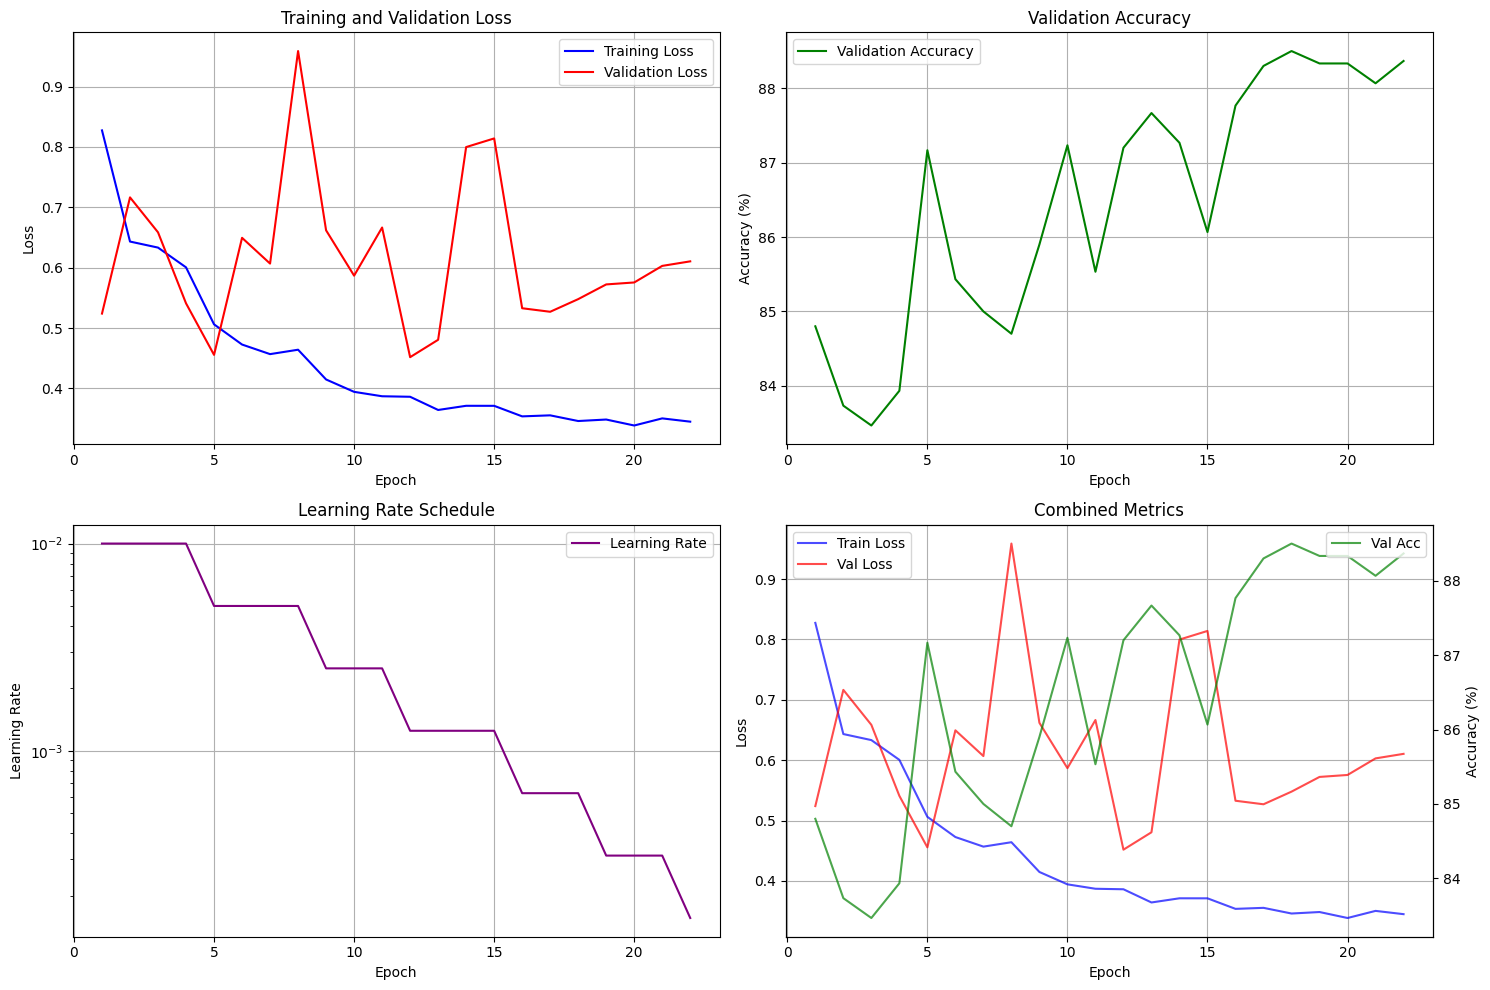

FINAL RESULTS:
Test Accuracy: 88.00%
Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop      0.906     0.937     0.921       300
              Forest      0.929     0.910     0.919       300
HerbaceousVegetation      0.873     0.800     0.835       300
             Highway      0.779     0.927     0.846       300
          Industrial      0.866     0.947     0.904       300
             Pasture      0.918     0.857     0.886       300
       PermanentCrop      0.884     0.760     0.817       300
         Residential      0.811     0.987     0.890       300
               River      0.913     0.737     0.815       300
             SeaLake      0.969     0.940     0.954       300

            accuracy                          0.880      3000
           macro avg      0.885     0.880     0.879      3000
        weighted avg      0.885     0.880     0.879      3000



In [97]:
test_accuracy, train_losses, val_losses, val_accuracies = train(
    print_every=5, 
    patience=10, 
    epochs=100, 
    learning_rate=0.01,
    batch_size=32,
    use_scheduler=True
)

# Вывод

В работе успешно применен transfer learning для классификации спутниковых снимков EuroSAT. Использована предобученная MobileNetV3 Small с заморозкой сверточных слоев и дообучением только классификатора. 

На тестовой выборке достигнута точность **88%** при сбалансированных метриках по всем 10 классам. Подход доказал эффективность даже при минимальном дообучении модели.

Работа показала, что предобученные CNN модели хорошо переносят знания на задачи спутниковой съемки, требуя мало вычислительных ресурсов для дообучения.